In [10]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
batch_size = 64
num_classes = 10
learning_rate = 0.001
num_epochs = 10

In [27]:
train_dataset = torchvision.datasets.MNIST(root = './data',
                                           train = True,
                                           transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1307,), std = (0.3081,))]),
                                           download = True)


test_dataset = torchvision.datasets.MNIST(root = './data',
                                          train = False,
                                          transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1325,), std = (0.3105,))]),
                                          download=True)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)


test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

In [28]:
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super(LeNet5, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(400, 120)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return F.log_softmax(out, dim=1) #return out

In [29]:
model = LeNet5(num_classes).to(device)

#Setting the loss function
cost = nn.CrossEntropyLoss()

#Setting the optimizer with the model parameters and learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#this is defined to print how many steps are remaining when training
total_step = len(train_loader)

In [30]:
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        images = images.to(device)
        labels = labels.to(device)
        
        #Forward pass
        outputs = model(images)
        loss = cost(outputs, labels)
        	
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        	
        if (i+1) % 500 == 0:
            print ('Epoch [{}/{}],  Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

Epoch [1/10],  Loss: 0.1692
Epoch [2/10],  Loss: 0.0179
Epoch [3/10],  Loss: 0.0363
Epoch [4/10],  Loss: 0.0108
Epoch [5/10],  Loss: 0.0213
Epoch [6/10],  Loss: 0.0552
Epoch [7/10],  Loss: 0.0215
Epoch [8/10],  Loss: 0.0155
Epoch [9/10],  Loss: 0.0092
Epoch [10/10],  Loss: 0.0022


In [31]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the network on the 10000 test images: 99.19 %


In [32]:
model.eval()

LeNet5(
  (layer1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=400, out_features=120, bias=True)
  (relu): ReLU()
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)

In [33]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [34]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [35]:
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = 1,
                                           shuffle = True)

In [38]:
epsilons = [0, .05, .1, .15, .2, .25, .3, .4, .5, .6]

In [39]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 8196 / 10000 = 0.8196
Epsilon: 0.05	Test Accuracy = 8040 / 10000 = 0.804
Epsilon: 0.1	Test Accuracy = 7879 / 10000 = 0.7879
Epsilon: 0.15	Test Accuracy = 7720 / 10000 = 0.772
Epsilon: 0.2	Test Accuracy = 7527 / 10000 = 0.7527
Epsilon: 0.25	Test Accuracy = 7341 / 10000 = 0.7341
Epsilon: 0.3	Test Accuracy = 7120 / 10000 = 0.712
Epsilon: 0.4	Test Accuracy = 6643 / 10000 = 0.6643
Epsilon: 0.5	Test Accuracy = 5266 / 10000 = 0.5266
Epsilon: 0.6	Test Accuracy = 3842 / 10000 = 0.3842


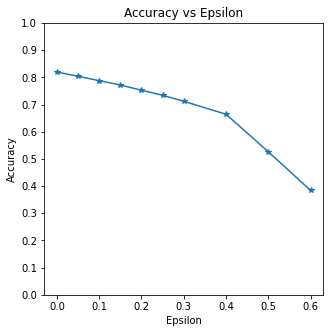

In [42]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .7, step=0.1))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

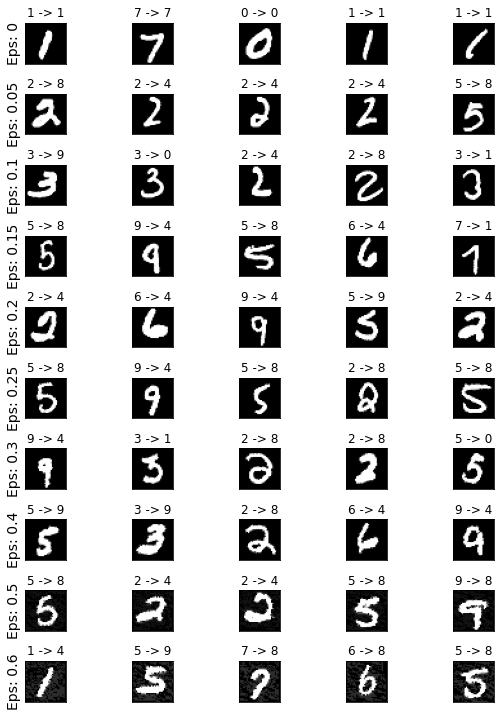

In [43]:
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()